#### Hinweise zum Ablauf des Notebooks:
---
<div class="alert alert-info">
Das Notebook ist in Abschnitte unterteilt, die den Schülerinnen und Schülern die Möglichkeit geben, eigenständig zu arbeiten und zu experimentieren. Diese Abschnitte werden von Erklärungen und Beschreibungen unterbrochen, die sicherstellen sollen, dass die grundlegenden Konzepte verstanden wurden. Die Erklärungen und Beschreibungen können auch außerhalb des Notebooks erfolgen, beispielsweise durch mündliche Erklärungen, interaktive Diskussionen oder an der Tafel. Falls es Fragen zum Code oder zum Verständnis gibt, können die Schülerinnen und Schüler diese jederzeit stellen. Gelegentlich kann es vorkommen, dass Fragen schriftlich beantwortet werden müssen, bevor sie in einem kurzen Gespräch besprochen werden.

Die Diskussionen und Erklärungen können auch in den Markdown-Zellen festgehalten werden, um später darauf zurückgreifen zu können. Bitte beachten Sie, dass für die Bearbeitung der Aufgabe grundlegende Kenntnisse in Python erforderlich sind. Im Idealfall sollten die Schülerinnen und Schüler bereits an der CMS Masterclass oder einem ähnlichen Programm teilgenommen haben, um einige der Konzepte bereits kennengelernt zu haben.
</div>

#### Was in diesem Notebook angeschnitten wird:
---

1) Handhaben von großen Datensätzen
    * Betrachten und Verarbeiten von großen Datensätzen
    * Unterschied zwischen simulierten und tatsächlich gemessenen Daten
    * Visualisierung von physikalischen Größen mithilfe von Histogrammen
2) Algorithmenentwicklung für eine Teilchen-Rekonstruktion
    * Verwendung von Informationen aus den CMS-Detektoren, um Teilchen (Kandidaten für Z und Higgs Bosonen) zu rekonstruieren
3) Motivation einiger (neuer) physikalischer Kriterien zur besseren Untergrundunterdrückung
    * Erklärung der Bedeutung von physikalischen Kriterien, wie z.B. der invarianten Masse, dem, Transversalimpuls, der relativen Isolation
4) Anwendung der physikalischen Kriterien zur Untergrundunterdrückung
5) Bestimmung der Signifikanz eines Überschusses und Ableitung bzgl. einer möglichen Beobachtung
    * Verwendung von einfachen statistischen Methoden zur Berechnung der Signifikanz von Signalereignissen gegenüber dem Untergrund
    * Diskussion von möglichen Beobachtungen und Interpretation der Ergebnisse
    
Es wird empfohlen, dass die Schülerinnen und Schüler über grundlegende Python-Kenntnisse verfügen, um das Notebook bearbeiten zu können. Auch ist es möglich, die notwendigen Python Kenntnisse während des Bearbeitens, z.B. in weiteren Code Zellen, näherzubringen. Auch können einige der Konzepte, die in diesem Notebook vorkommen, durch CMS-Masterclass oder ähnlichen Veranstaltungen bereits bekannt sein und bauen stellenweise darauf auf.


## Suche nach dem Higgs Boson im $\mathrm{H} \rightarrow ZZ \rightarrow 4\ell$ Kanal.
#### ein vereinfachter Ausschnitt einer Analyse
---

In der nachfolgenden Zelle werden Bibliotheken und Hilfefunktionen importiert, die für die Bearbeitung der Aufgabe benötigt werden. Die Verwendung von Bibliotheken und Funktionen, die bereits von anderen Entwicklern erstellt wurden, spart Zeit und vermeidet das Schreiben von redundanter Code. Es ist daher eine gängige Praxis, Bibliotheken und Funktionen zu importieren, die für die Entwicklung und Durchführung von Experimenten benötigt werden.

In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
from pprint import pprint

from utils import Filter, get_lepton_names_by_flavour, prev_hists, plot_masses, clear_hist_plots

Zunächst laden wir die Datensätze in das Notebook. Diese beinhalten Simulationen für den Untergrund und das Signal, welches in Form eines Higgs-Bosons mit einer Masse von $125\, \mathrm{GeV}/c^2$ angenommen wird. Wir laden auch die tatsächlich durchgeführte Messung für die anfängliche Visualisierung. Die tatsächliche Anwendung auf die durchgeführte Messung erfolgt erst zum Schluss.

In [2]:
dfs = pd.read_csv("data/MC_2012_H_to_ZZ_to_4L_[100,151].csv.gz", header=[0, 1])  # signal MC
dfb = pd.read_csv("data/MC_2012_ZZ_to_4L_[100,151].csv.gz", header=[0, 1])  # signal MC
dfm = pd.read_csv("data/CMS_Run2012[B,C]_[100,151].csv.gz", header=[0, 1])

print("Signal simulation")
display(dfs.head())

print("Background simulation")
display(dfb.head())


Signal simulation


event_information lepton_0                                            
            channel        E       px      py       pz flavour charge   
0                 2   40.520 -36.9470  14.478   8.1968     1.0    1.0  \
1                 0   45.575 -33.0500 -30.283   8.2250     0.0   -1.0   
2                 0   63.087 -23.3130  23.232  53.8220     0.0   -1.0   
3                 0   43.890   9.2923 -40.068  15.3150     0.0   -1.0   
4                 0   84.498 -28.3290 -17.593 -77.6390     0.0    1.0   

            lepton_1           ...  Z1      Z2             four_lep           
   relpfiso        E       px  ...  py  pz   E  px  py  pz        E  px  py   
0  0.107879   32.044 -10.1480  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN  \
1  0.008728   57.617   9.3309  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   
2  0.083510   35.279  26.6930  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   
3  0.019456   30.698 -21.0470  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   
4  0.070871   33.163  30.6340  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   

       
   pz  
0 NaN  
1 NaN  
2 NaN  
3 NaN  
4 NaN  

[5 rows x 41 columns]

Background simulation


event_information lepton_0                                             
            channel        E      px       py        pz flavour charge   
0                 0  131.840  49.035 -24.0350 -120.0000     0.0   -1.0  \
1                 1  112.090  15.444 -28.5690 -107.2800     1.0   -1.0   
2                 0   51.086  12.700  40.9880  -27.7210     0.0   -1.0   
3                 0   41.822  41.330   6.2322   -1.4221     0.0   -1.0   
4                 2   56.155  34.641 -21.4060  -38.6670     1.0    1.0   

            lepton_1           ...  Z1      Z2             four_lep           
   relpfiso        E       px  ...  py  pz   E  px  py  pz        E  px  py   
0  0.113952   23.322  13.3900  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN  \
1  0.022230   25.031   4.5001  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   
2  0.063375  111.560 -19.1620  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   
3  0.015386   89.043 -27.6750  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   
4  0.102327  165.820 -28.0560  ... NaN NaN NaN NaN NaN NaN      NaN NaN NaN   

       
   pz  
0 NaN  
1 NaN  
2 NaN  
3 NaN  
4 NaN  

[5 rows x 41 columns]

In den geladenen Datensätzen sind immer jeweils vier Leptonen enthalten, die mit den Bezeichnungen `lepton_0`, `lepton_1`, `lepton_2` und `lepton_3` gekennzeichnet sind. Diese Leptonen werden, die Rekonstruktion von Z-Boson Kandidaten und der Anwendung einiger der Filter benötigt. Um auf die Leptonen in den Datensätzen zuzugreifen, können wir die Syntax `dataframe["lepton_0"]`, ähnlich zu dem nativen Python `dict` verwenden.

In [3]:
dfs["lepton_0"]

,E,px,py,pz,flavour,charge,relpfiso
0,40.520,-36.9470,14.478,8.1968,1.0,1.0,0.107879
1,45.575,-33.0500,-30.283,8.2250,0.0,-1.0,0.008728
2,63.087,-23.3130,23.232,53.8220,0.0,-1.0,0.083510
3,43.890,9.2923,-40.068,15.3150,0.0,-1.0,0.019456
4,84.498,-28.3290,-17.593,-77.6390,0.0,1.0,0.070871
...,...,...,...,...,...,...,...
39930,66.947,9.1426,-57.832,-32.4620,1.0,-1.0,0.034332
39931,114.800,-9.7699,-45.499,-104.9500,0.0,-1.0,0.016650
39932,56.528,-36.9690,-25.133,34.5990,0.0,1.0,0.180502
39933,182.270,52.9680,-25.111,-172.5900,0.0,1.0,0.058888



Auf einzelne Größen wie die Energie, den Impuls o. Ä. kann dann via `dataframe["lepton_0"]["px"]` oder `dataframe[["lepton_0", "lepton_1"]]["px"]` zugegriffen werden. `"flavour"` unterscheidet zwischen einem Myon `0` und einem Elektron `1`. Im Detail wird diese Unterscheidung, sowie die elektrische Ladung `charge` lediglich beim Rekonstruktionsschritt benötigt. Die Größe `relpfiso` wird bei der Anwendung eines Filterschrittes benötigt und wird zu einem späteren Zeitpunkt an der Tafel motiviert. 

Mit `dataframe["lepton_0"]["px"]` oder `dataframe[["lepton_0", "lepton_1"]]["px"]` kann auf bestimmte Größen wie den Impuls oder die Energie der einzelnen Leptonen zugegriffen werden. `"flavour"` unterscheidet dabei zwischen einem Myon (`0`) und einem Elektron (`1`). Diese Unterscheidung und auch die Angabe der elektrischen Ladung `"charge"` werden später beim Rekonstruktionsschritt benötigt.

Die Größe `relpfiso` (relative Isolation des jeweiligen Teilchens) wiederum wird erst bei einem späteren Filterschritt benötigt und ist für die nachfolgende Rekonstruktion nicht notwendig. Es ist gängig, alle notwendigen Informationen zu Teilchen o. Ä. in einem Datensatz zusammenzufassen, um diese nicht später hinzuzufügen zu müssen.

Um den Umgang mit den Datensätzen besser zu verinnerlichen, können wir eine erste Aufgabe angehen:

<div class="alert alert-info">
Zeige die Impulskomponente in Z-Richtung (also die Impulskomponente entlang der Strahlachse) für das dritte und vierte Lepton im Datensatz an.

Hier ein paar Schritte, die dir helfen können, die Aufgabe zu lösen:

Verwende den Datensatz, den wir in der vorherigen Zelle geladen haben.
Greife auf die Impulskomponente in Z-Richtung eines Leptons zu, indem du den Index des Leptons und den String "pz" kombinierst.
Denke daran, dass die Indizierung in Python bei 0 beginnt, d.h. das erste Lepton hat den Index 0, das zweite den Index 1 usw.
Wenn du diese Schritte befolgst, solltest du in der Lage sein, die Impulskomponente in Z-Richtung für das dritte und vierte Lepton aus dem Datensatz auszulesen.
</div>

In [4]:
# Leere Zelle für die Aufgabe

Um das Verständnis der Datensätze zu vertiefen, ist es wichtig zu wissen, dass neben den Leptonen auch Informationen zu den zu rekonstruierenden Objekten `"Z1"` und `"Z2"` vorhanden sind. Diese Objekte sind Kandidaten für die Z-Bosonen und werden aus im nachfolgenden Rekonstruktionsschritt aus den Leptonen zusammengesetzt, die in einem Ereignis vorhanden sind. Der daraus resultierende `"four_lep"` Eintrag ist der Kandidat für das Higgs-Boson. Ebenso wie die Leptonen haben die Z und Higgs Kandidaten ebenfalls eine Energie und einen Impuls, welcher in die einzelnen Komponenten aufgeteilt werden kann. 

Es ist zu beachten, dass `"Z1"`, `"Z2"` und `"four_lep"` initial leer sind und mit `NaN`s gefüllt sind, bis sie im Rekonstruktionsschritt für jedes Ereignis berechnet und eingetragen werden.

Zusätzlich wird mit `dataframe["event_informations"]["channel"]` zwischen den verschiedenen Zerfallskanälen unterschieden. Es gibt den Kanal mit vier Leptonen gleichen Flavours, also entweder vier Myonen (`0`) oder vier Elektronen (`1`), und den Mischkanal mit zwei Myonen und zwei Elektronen (`2`). Diese Information ist relevant für die Rekonstruktion, da die Z-Bosonen nur in ein Leptonen-Paar des gleichen Flavours zerfallen kann, es also in der Rekonstruktion von den Z-Bosonen Kandidaten berücksichtigt werden muss.

Vor dem Rekonstruktionsprozess muss einige Vorarbeiten geleistet werden, um die benötigten Größen berechnen zu können. Eine solche zentrale Größe ist die invariante Masse, die aus den Impulsen und Energien der Zerfallsprodukte oder des jeweiligen Teilchens berechnet werden kann.

Die invariante Masse ist eine wichtige Größe in der Teilchenphysik, da sie eine Aussage darüber gibt, welche Teilchen an einem bestimmten Zerfall beteiligt sind. Sie ist insofern "invariant", als sie unabhängig von der Wahl des Bezugssystems ist. Dies bedeutet, dass die invariante Masse für dasselbe Teilchenpaar in verschiedenen Bezugssystemen immer denselben Wert hat.

In der Anwendung wird die invariante Masse oft zur Teilchenidentifikation verwendet, welche durch den Zerfall eines anderen Teilchens entstanden sind. Hierbei kann die invariante Masse des Zerfallsprodukts mit der Masse eines bestimmten Teilchens verglichen. Für den Fall, dass die berechnete invariante Masse in der Nähe der bekannten Masse eines bekannten Teilchens liegt, kann man mit hoher Wahrscheinlichkeit davon ausgehen, dass das Zerfallsprodukt aus diesem Teilchen stammt.
<div class="alert alert-info">
Wie ist die invariante Masse für ein Teilchen definiert?
Wie sieht die Definition für mehrere Teilchen aus?

Implementieren Sie die Berechnung der invarianten Masse für ein Teilchen in der nachfolgenden `calculate_invariant_mass` Funktion.
</div>

In [5]:
# Berechnung der Invarianten Masse
def calculate_invariant_mass(energy, px, py, pz):
    # Berechne den Quadrat der invarianten Masse, wenn die Energie und einzelnen Impulskomponenten gegeben sind
    mass_square = energy ** 2 - px ** 2 - py ** 2 - pz ** 2

    # Da diese Funktion allgemein Funktionieren soll muss der Fall betrachtet werden, dass
    # mass_square < 0 ergibt. Dies ist nicht physikalishc und wird durch np.nan (not a number) ersetzt
    try:
        # Für den Fall, dass es sich bei energy, px, py, pz jeweils nur um eine Zahl handelt:
        return np.nan if mass_square < 0 else np.sqrt(mass_square)
    except ValueError:
        # Für den Fall, dass es sich bei energy, px, py, pz jeweils um numpy arrays handelt
        mass_square[mass_square < 0] = np.nan
        return np.sqrt(mass_square)
    
# Mögliche Variablen für das Testen... um welches Teilchen könnte es sich handeln? 
particle_E = 97.5   # GeV
particle_px = 7.8   # GeV
particle_py = 32.5  # GeV
particle_pz = 13.9  # GeV
print(calculate_invariant_mass(particle_E, particle_px, particle_py, particle_pz))

# Bei mehreren gebenen Teilchen
particle_E  = np.array([97.5, 48.4])   # GeV
particle_px = np.array([7.8, 3.2])   # GeV
particle_py = np.array([32.5, 21.7])  # GeV
particle_pz = np.array([13.9,36.1])  # GeV
print(calculate_invariant_mass(particle_E, particle_px, particle_py, particle_pz))

# Bei mehreren gebenen Teilchen, welche in der Rekonstruktion kombiniert werden können
print(calculate_invariant_mass(particle_E.sum(), particle_px.sum(), particle_py.sum(), particle_pz.sum()))

90.53148623545292
[90.53148624 23.62667983]
125.41200102063598


Die Berechnung der Invarianten Massen wird im Weiteren auch für die Darstellung der Masseverteilungen verwendet. Der hierzu verwendeten Funktion `plot_masses` wird die `calculate_invariant_mass` Funktion übergeben. Um es nicht ständig übergeben zu müssen, wird diese als die Defaultfunktion mittels `partial` wie folgt gesetzt:

In [6]:
from functools import partial
plot_masses = partial(plot_masses, mass_function=calculate_invariant_mass)

Als Nächstes folgt der eigentliche Rekonstruktionsschritt. Die Motivation hinter der Vorgehensweise wird an der Tafel besprochen. Anschließend soll die `perform_reconstruction` Funktion mit dem zusätzlichen Wissen um einige Code-Abschnitte ergänzt werden, um eine erfolgreiche Rekonstruktion durchzuführen.

In [7]:
from tqdm import tqdm
import time

def perform_reconstruction(df):
    z_boson_mass = 91.1876  # Die Masse des Z-Bosons in GeV/c^2

    loop_timer = time.time()
    
    # Schleife über jedes Ereignis im DataFrame unter Verwendung der tqdm-Bibliothek zur Fortschrittsanzeige
    for i, event in tqdm(enumerate(df.iloc()), total=df.shape[0]):
        # Wenn das Ereignis im Misch-Kanal ist
        if event.event_information.channel == 2:
            muon_1, muon_2 = get_lepton_names_by_flavour(event, flavour=0)  # Leptonen die Myonen entsprechen
            electron_1, electron_2 = get_lepton_names_by_flavour(event, flavour=1)  # Leptonen die Elektronen entsprechen

            # Kombiniere alle möglichen Leptonenpaare (hier nur Muon-Muon- und Elektron-Elektron-Paare)
            possible_lepton_pairs = [(muon_1, muon_2), (electron_1, electron_2)]

        else:
            # Wenn das Ereignis nur Elektronen/Myonen hat, kombiniere alle möglichen
            # Leptonenpaare (in diesem Fall alle Kombinationen von vier Leptonen)
            #
            # Wie viele Kombinationsmöglichkeiten existieren bei 4 Leptonen? 
            # Wie viele Kombinationen entstehen, wenn 5 oder 6 Leptonen betrachtet werden?
            #
            # Schreibe alle Kombinationsmöglichkeiten für vier Leptonen auf, orientiere dich an
            # den ersten zwei gegebenen Kombinationen
            possible_lepton_pairs = [
                ("lepton_0", "lepton_1"),
                ("lepton_0", "lepton_2"),
                ("lepton_0", "lepton_3"),
                ("lepton_1", "lepton_2"),
                ("lepton_1", "lepton_3"),
                ("lepton_2", "lepton_3"),
            ]

        z_candidates = {}  # Zum speicheren aller Kandidaten für die Z-Bosonen
        for first_lepton, second_lepton in possible_lepton_pairs:
            # Summation der Impulskomponenten/Energien der Leptonen
            combined_px = event[first_lepton]["px"] + event[second_lepton]["px"]
            combined_py = event[first_lepton]["py"] + event[second_lepton]["py"]
            combined_pz = event[first_lepton]["pz"] + event[second_lepton]["pz"]
            combined_E = event[first_lepton]["E"] + event[second_lepton]["E"]

            # Berechne die invariante Masse des Leptonenpaares durch die implementierte Funktion
            M = calculate_invariant_mass(combined_E, combined_px, combined_py, combined_pz)

            # Überprüfe, ob die kombinierten Leptonen eine elektrische Gesamtladung von Null haben
            combined_electric_charge = event[first_lepton]["charge"] + event[second_lepton]["charge"]
            if combined_electric_charge == 0:
                # Wenn ja, speichere die Impuls- und Masseninformationen des Leptonenpaares als Kandidat für das Z-Boson
                z_candidates[(first_lepton, second_lepton)] = {
                    "px": combined_px, 
                    "py": combined_py, 
                    "pz": combined_pz, 
                    "E": combined_E, 
                    "M": M, 
                }

        # Hier wird nach einem Z-Boson Kandidat gesucht, welcher am nächsten bei der Z-Bosonen Masse ist
        # Hierzu erstellen wir zunächst zwei Defaults
        nearest_z_mass_lepton_pair, nearest_candidate_z_mass_to_z_boson = None, 9999
        # Und iterieren über alle Z-Boson Kandidaten
        for lepton_pair, z_values in z_candidates.items():
            # Sofern der aktuelle Kandidat näher an der Z-Bosonen Masse wird das dazugehörige Leptonenpaar
            # und der Abstand zu der Z-Bosonen Masse gespeichert und nach einem besseren Kandidaten gesucht
            if abs(z_boson_mass - z_values["M"]) < nearest_candidate_z_mass_to_z_boson:
                nearest_candidate_z_mass_to_z_boson = abs(z_boson_mass - z_values["M"])
                nearest_z_mass_lepton_pair = lepton_pair

        # Wenn dieser Kandidat gefunden wurde:
        if nearest_z_mass_lepton_pair is not None:
            # Die Energie und alle Impulskomponente von Z1 werden entsprechend gesetzt
            df.loc[i, ("Z1", "E")] = z_candidates[nearest_z_mass_lepton_pair]["E"]
            df.loc[i, ("Z1", "px")] = z_candidates[nearest_z_mass_lepton_pair]["px"]
            df.loc[i, ("Z1", "py")] = z_candidates[nearest_z_mass_lepton_pair]["py"]
            df.loc[i, ("Z1", "pz")] = z_candidates[nearest_z_mass_lepton_pair]["pz"]

            # Alle Kombinationen, welche eines der Leptonen von nearest_z_mass_lepton_pair beinhalten
            # werden entfernt
            first_used_lepton, second_used_lepton = nearest_z_mass_lepton_pair
            for lepton_pair in list(z_candidates.keys()):
                if first_used_lepton in lepton_pair or second_used_lepton in lepton_pair:
                    z_candidates.pop(lepton_pair)  # Hier wird es entfernt, wenn die obige Bedingung erfüllt wird (*)

        # Anschließend suchen wir bei den übrigen Z-Boson Kandidaten (Wie viele sind noch übrig?)
        # nach dem Z-Boson Kandidaten für das zweite Z-Boson und wählen den Kandidatena us mit dem größten
        # Transversalimpuls.
        # Hierzu wieder zwei Default-Werte
        highest_remaining_z_pt_lepton_pair, highest_remaining_z_pt = None, 0
        # Iteration über die übrigen Z-Boson Kandidaten welche noch übrig sind (siehe (*) oben) 
        for lepton_pair, z_values in z_candidates.items():
            # Berechnung des Transversalimpulses von dem jeweiligen Z-Boson
            pt = np.sqrt(z_values["px"] ** 2 + z_values["py"] ** 2)
            # Merken des Kandidaten, wenn dieser einen größeren Transversalimpuls hat als 
            # der bisher gefundene Kandidat
            if pt > highest_remaining_z_pt:
                highest_remaining_z_pt = pt
                highest_remaining_z_pt_lepton_pair = lepton_pair

        # Sollte dieser zweite Kandidat existieren wird dieser entsprechend gesetzt
        if highest_remaining_z_pt_lepton_pair is not None:
            df.loc[i, ("Z2", "E")] = z_candidates[highest_remaining_z_pt_lepton_pair]["E"]
            df.loc[i, ("Z2", "px")] = z_candidates[highest_remaining_z_pt_lepton_pair]["px"]
            df.loc[i, ("Z2", "py")] = z_candidates[highest_remaining_z_pt_lepton_pair]["py"]
            df.loc[i, ("Z2", "pz")] = z_candidates[highest_remaining_z_pt_lepton_pair]["pz"]

    print(f"Die Rekonstruktion, welche eine Schleife benutzt benötigte {time.time() - loop_timer} Sekunden")

    vectorized_timer = time.time()

    # Sollten beide Z-Boson Kandidaten existieren, dann werden die Energie und Transversalimpulskomponenten von
    # den beiden Z-Boson Kandidaten kombiniert und Higgs Boson Kandidaten bestehend aus vier Leptonen bestimmt.
    # Da hier keine Kombinatorik notwendig, ist können wir die Addition Spaltenweise durchführen, was deutlich schneller
    # ist als der Event Loop
    if nearest_z_mass_lepton_pair is not None and highest_remaining_z_pt_lepton_pair is not None:
        df.loc[:, ("four_lep", "E")] = df.loc[:, ("Z1", "E")] + df.loc[:, ("Z2", "E")]
        df.loc[:, ("four_lep", "px")] = df.loc[:, ("Z1", "px")] + df.loc[:, ("Z2", "px")]
        df.loc[:, ("four_lep", "py")] = df.loc[:, ("Z1", "py")] + df.loc[:, ("Z2", "py")]
        df.loc[:, ("four_lep", "pz")] = df.loc[:, ("Z1", "pz")] + df.loc[:, ("Z2", "pz")]

    print(f"Die Rekonstruktion, welche Spaltenweise die Größen berechnete benötigte {time.time() - vectorized_timer} Sekunden")

    # Ausgabe des nun vollständigen Datensatzes
    return df
            

Mit der so vervollständigten Funktion kann die Rekonstruktion für alle Datensätze durchgeführt werden.


Da dieser Schritt länger dauert, is es ratsam nach einer erfolgreichen Rekonstruktion die nun vollständigen Datensätze zwischenzuspeichern und beim neu starten das Notebook diesen rekonstruierten Datensatz direkt zu laden und den Rekonstruktionsschritt überspringen. Folgender Code kann für das Speichern ausgeführt werden. Wichtig ist hier, dass der neue Ordner bereits vorhanden sein muss.

Sollte die Datensätze in dem neuen Ordner nicht gefunden werden, dann startet die Rekonstruktion und ergänzt die so geladenen Datensätze. Anschließend werden diese dann in dem entsprechenden Ordner gespeichert. Beim nochmaligem Ausführen werden diese Datensätze gefunden und direkt geladen

Da während des Rekonstruktionsschrittes keine weitere Aktion in dem Notebook möglich ist, kann eine Pause eingelegt werden.

In [8]:
import os

new_directory = "data_reconstructed"

os.makedirs(new_directory, exist_ok=True)

try:
    dfs = pd.read_csv(os.path.join(new_directory, "MC_2012_H_to_ZZ_to_4L_[100,151].csv.gz"), header=[0, 1])
    dfb = pd.read_csv(os.path.join(new_directory, "MC_2012_ZZ_to_4L_[100,151].csv.gz"), header=[0, 1])
    dfm = pd.read_csv(os.path.join(new_directory, "CMS_Run22[B,C]_[100,151].csv.gz"), header=[0, 1])
except FileNotFoundError:
    dfs = perform_reconstruction(dfs)
    dfb = perform_reconstruction(dfb)
    dfm = perform_reconstruction(dfm)
    dfs.to_csv(os.path.join(new_directory, "MC_2012_H_to_ZZ_to_4L_[100,151].csv.gz"), index=False)
    dfb.to_csv(os.path.join(new_directory, "MC_2012_ZZ_to_4L_[100,151].csv.gz"), index=False)
    dfm.to_csv(os.path.join(new_directory, "CMS_Run22[B,C]_[100,151].csv.gz"), index=False)

Als Nächstes werden die ausgewählten Kandidaten für Z-Bosonen und Higgs-Bosonen als Massenverteilungen visualisiert. Dabei wird die Rolle von Verteilungen in der Physik und der Aspekt des Zufalls in der Quantenphysik an der Tafel besprochen. Für die tatsächliche Visualisierung der betrachteten Größen wird die `plot_masses` Hilfsfunktion genutzt. Die beispielhafte Nutzung wird in der nachfolgenden Zelle dargestellt. Vor jeder Nutzung können die früher verwendeten Histogramme über `clear_hist_plots()` zurückgesetzt werden. Die Betrachtung dieser wird vor allem in dem nächsten Abschnitt hilfreich sein. Diese Funktionen können und sollen auch an anderen Stellen weiterverwendet werden. 
<div class="alert alert-info">
    Was ist auffällig bei dem Vergleich der Massenverteilungen der invarianten Masse der vier Leptonen? 
    Welche der Verteilungen sehen ähnlich aus?
</div>

Anschließend werden vorerst nur die Rohverteilungen der Simulationen betrachtet, welche noch nicht skaliert wurden. Die Massenverteilung der Messung werden wir erst nach dem nächsten Schritt verwenden.

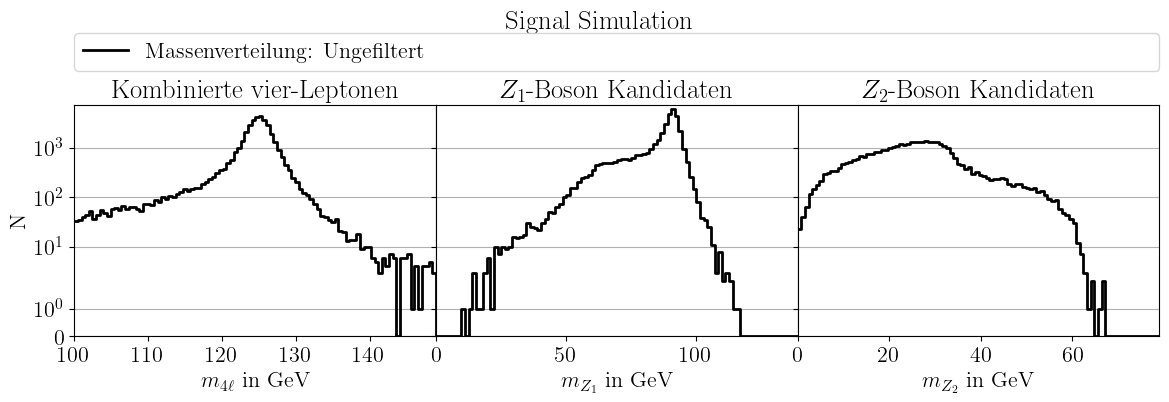

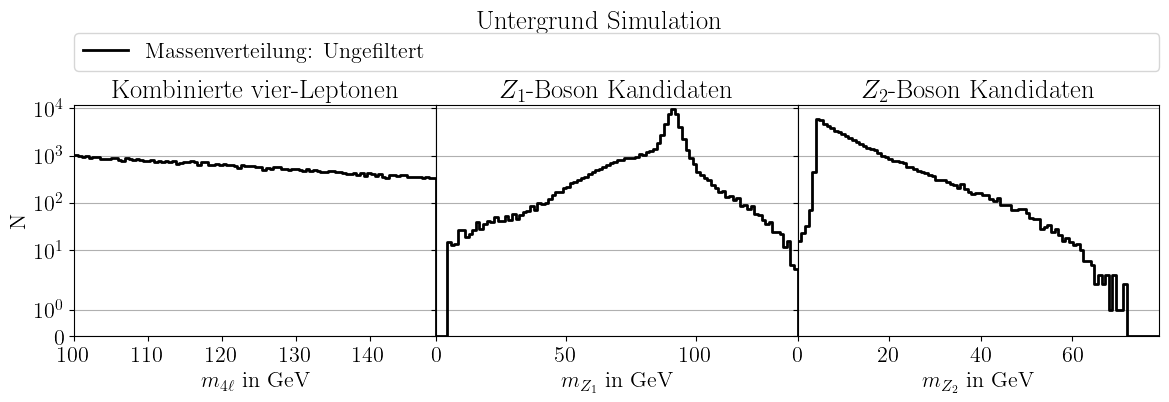

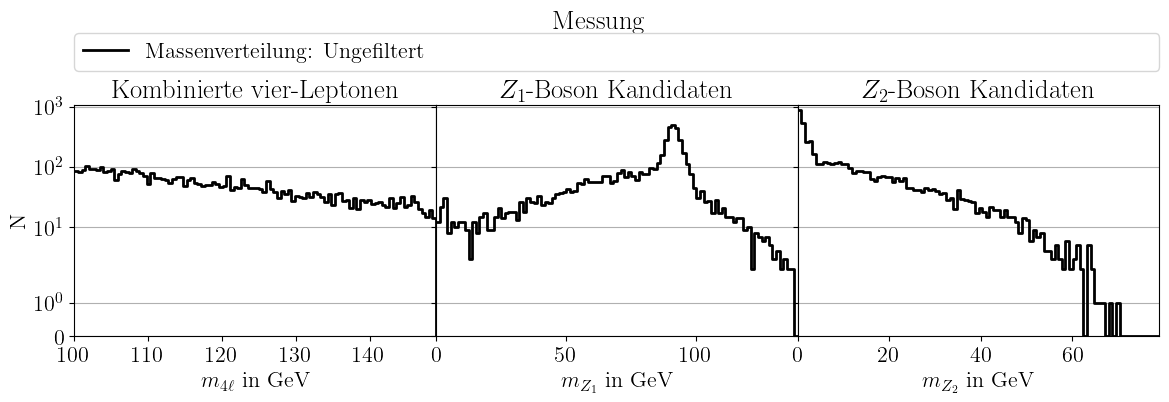

In [9]:
_ = dfs.pipe(clear_hist_plots).pipe(plot_masses, filter_name="Ungefiltert", title="Signal Simulation")
_ = dfb.pipe(clear_hist_plots).pipe(plot_masses, filter_name="Ungefiltert", title="Untergrund Simulation")
_ = dfm.pipe(clear_hist_plots).pipe(plot_masses, filter_name="Ungefiltert", title="Messung")

Nachdem die Frage(n) beantwortet wurde(n), soll das Ziel verfolgt werden, die Datensätze so zu bereinigen, dass im besten Fall eine Resonanz von einem möglichen Higgs Boson zu sehen ist. Das gesamte Vorgehen soll anhand der simulierten Ereignisse durchgeführt werden, um keine Vorurteile in die Analyse einzubringen. In der Regel werden die Messdaten nicht direkt betrachtet, wie es oben durchgeführt wurde. Aus didaktischen Gründen ist es jedoch ratsam zu motivieren, warum die nachfolgende Bereinigung in Form von angewendeten Filtern angewendet werden sollte. 

Die Motivation einzelner Filter, insbesondere des Filters der relativen Isolation, wird an der Tafel motiviert, ebenso wie ein guter Anhaltspunkt für die Wahl der Grenzen bei den Intervallen der Massen der Z-Bosonen.

Die Anwendung einzelner Filter erfolgt sehr einfach über `dataframe.pipe(filtername, filterargumente).pipe(filername, filterargumente)....`

Folgende Filter stehen zur Verfügung:

* `Filter.min_pt_of_lepton` mit `min_pt_electron` und `min_pt_muon` als notwendige Argumente
* `Filter.relative_isolation_of_lepton`, mit dem notwendigen `relative_isolation_value` Argument
* `Filter.min_lepton_number` ist ein argumentloser Filter ebenso wie
* `Filter.neutral_charge`, die nach jedem Einsatz von anderen Filtern angewendet werden sollte, da diese alle Ereignisse entfernen, in denen aufgrund der Anwendung von anderen Filtern nicht mehr vier Leptonen vorhanden sind oder keine elektrisch neutrale Ladungskombination mehr existiert.
* `Filter.z_masses` mit den eingrenzenden Massenwerten `z1_mass_min`, `z1_mass_max`, `z2_mass_min`, `z2_mass_max`

Alle festgelegten Werte können in einer gemeinsamen Sammlung gespeichert werden, um einen einfachen Zugriff darauf zu ermöglichen. Sobald sich auf ein Wert festgelegt wird, kann dieser den Default Wert überschreiben.

In [10]:
filter_arguments = {
    "min_pt_electron": 0,
    "min_pt_muon": 0,
    "relative_isolation_value": 9999,
    "z1_mass_min": 0,
    "z2_mass_min": 0,
    "z1_mass_max": 9999,
    "z2_mass_max": 9999,
}

Wieviele der Ereignisse in einem Schritt herausgefiltert werden kann über die zwei folgenden Hilfsfunktionen bestimmt werden, wobei vor dem Anwenden eines Filters die Anzahl der Eriegnisse, welche derzeit in dem Datensatz noch vorhanden sind, mittles `.pipe(set_n_events)` zwischengespeichert wird und nach dem Anwenden der Filter genutzt wird um mithilfe von `.pipe(print_n_events_change)` die Anzahl an Events vor und nach dem Anwenden eines Fitlers anzuzeigen.

In [11]:
N_EVENTS = None
def set_n_events(df):
    global N_EVENTS
    N_EVENTS = df.shape[0]
    return df
def print_n_events_change(df, filter_name="", reset=True):
    global N_EVENTS
    n_events_new = df.shape[0]
    relative_change = 100 * (1 - n_events_new / N_EVENTS)
    print(f"Filer: {filter_name}; Number of events: {N_EVENTS} -> {n_events_new}; Relative change: -{round(relative_change, 2)}%")
    if reset:
        N_EVENTS = None
    return df

{'min_pt_electron': 7,
 'min_pt_muon': 5,
 'relative_isolation_value': 9999,
 'z1_mass_max': 9999,
 'z1_mass_min': 0,
 'z2_mass_max': 9999,
 'z2_mass_min': 0}
Filer: min_pt_of_lepton; Number of events: 66192 -> 37085; Relative change: -43.97%


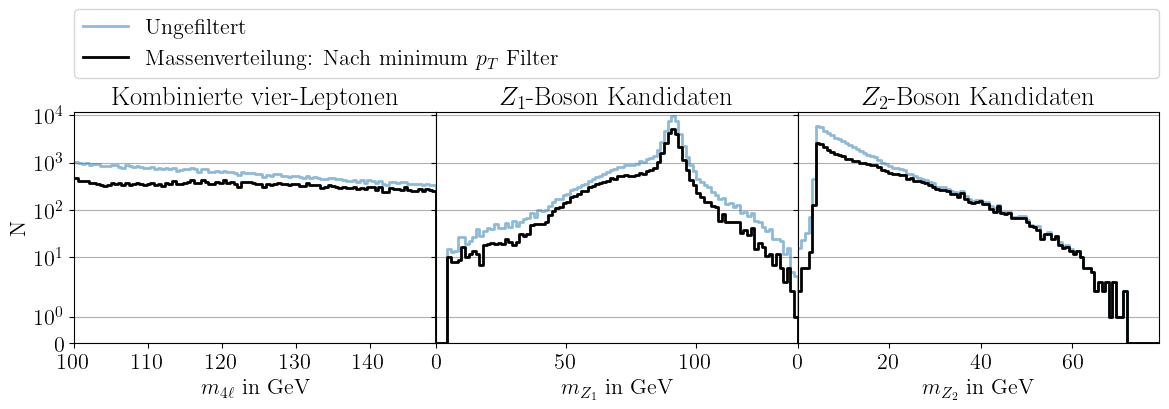

Filer: min_pt_of_lepton; Number of events: 39935 -> 34387; Relative change: -13.89%


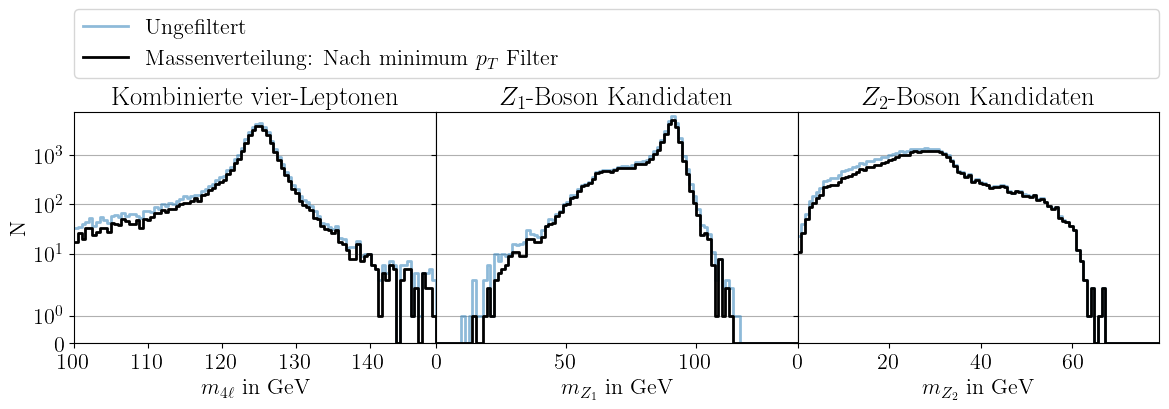

In [12]:
filter_arguments["min_pt_electron"] = 7
filter_arguments["min_pt_muon"] = 5

pprint(filter_arguments)

_ = (
    # choose the dataset. here: background simulation
    dfb
        # clear previous history and set the number of events
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # store the mass histograms
        .pipe(plot_masses, filter_name="Ungefiltert", show_plot=False)
        # apply the selected filter
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        # remove events where the reconstruction of the higgs boson is not possible anymore
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # print the number of filtered out events
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        # plot mass histogram comparison
        .pipe(plot_masses, filter_name="Nach minimum $p_T$ Filter")  
)

_ = (
    # choose the dataset. here: signal simulation
    dfs
        # clear previous history and set the number of events
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # store the mass histograms
        .pipe(plot_masses, filter_name="Ungefiltert", show_plot=False)
        # apply the selected filter
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        # remove events where the reconstruction of the higgs boson is not possible anymore
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # print the number of filtered out events
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        # plot mass histogram comparison
        .pipe(plot_masses, filter_name="Nach minimum $p_T$ Filter")
)

Das Ziel besteht darin, eine größtmögliche Reduzierung des Untergrunds bei bestmöglicher Beibehaltung des Signals zu erreichen. Dabei kann generell das Problem auftauchen, dass die begrenzte Größe des Messdatensatzes die Freiheit bei der Wahl der spezifischen Filtergrenzen einschränkt. Die bestmöglichen Filterergebnisse bei den simulierten Datensätzen haben nur wenig Nutzen, wenn kaum noch Ereignisse in der tatsächlichen Messung vorhanden sind. Aus diesem Grund sollten die jeweiligen Filtergrenzen nicht extrem gewählt werden. Bei Fragen und Diskussionen über die jeweiligen Filtergrenzen kann jederzeit auch der Tutor hinzugezogen werden.

Ein Beispiel ist der oben angewendete Filter nach dem minimalen Transversalimpuls. Er zeigt, dass die Reduktion der vier-Leptonen-invarianten Massenverteilung für den simulierten Untergrund größer im Vergleich zu dem Signal ist. Es ist möglich, dass weitere Filter größere Effekte zeigen als der Filter nach dem minimalen Transversalimpuls. Die Idee hinter diesem Filter besteht aber hauptsächlich darin, alle Leptonen zu entfernen, welche potenziell als solche fälschlich klassifiziert wurden. Die Unterscheidung in Elektronen und Myonen erfolgt lediglich aus dem Grund, dass die Myonen in dem Detektor besser detektiert werden können, weshalb sie einen geringeren minimalen Wert für den Transversalimpuls haben. Die gewählten Werte entsprechen den minimalen Transversalimpulsen, welche vom CMS Experiment gewählt wurden. Es ist möglich, größere Werte nach Wunsch selbstständig zu wählen.

<div class="alert alert-info">
    Welchen Massenbereich der vier-Leptonen-invarianten Masse adressiert der Filter besser? Hierzu können unterschiedliche und auch extreme Werte ausprobiert werden.
    Ab welchen Werten werden die meisten Ereignisse aus den Verteilungen herausgefiltert?
    Gibt es eine Kombination an Werten, bei denen mehr Signalereignisse als Untergrundereignisse entfernt werden?
</div>
    
Nach der Beantwortung der Fragen sollte die abschließende Wahl der Filtergrenzen getroffen werden. Sobald die Wahl getroffen ist, sollten diese nicht mehr geändert werden und (später endgültig) auf die Datensätze, einschließlich der tatsächlichen Messung, angewendet werden. Es wird empfohlen, eine Kopie dieses Datensatzes zu erstellen. Wenn die Datensätze groß sind, kann es vorkommen, dass eine solche Kopie RAM belegt, der nicht zur Verfügung steht. In diesem Fall muss eine andere Lösung gefunden werden. Für das Vorgehen hier reicht es, die Filter immer wieder anzuwenden und erst zum Schluss die Datensätze abzuspeichern, da der Filterschritt schnell genug abläuft.

---

Der nächste Filter, welcher verwendet werden kann, ist der nach der relativen Isolation von einzelnen Leptonen. Die relative Isolation als ein Filterkriterium wird verwendet, um den Leptonen mit einem hohen Impuls herauszufiltern, welche aus Quark oder Gluonen-Jets stammen. Die Isolation gibt dabei  das Verhältnis zwischen der Summe der transversalen Impulse von Teilchen in der Nähe von dem betrachteten Lepton zu dem transversalen Impuls des jeweiligen Leptons an.

Relative Isolation als solche ist ein sehr gutes Filterkriterium, da sie es ermöglicht, Ereignisse mit isolierten Leptonen, meist aus schwachen Zerfällen stammende, von Ereignissen mit nicht isolierten Leptonen (meist starke Wechselwirkungen) zu unterscheiden. Da die relative Isolation ein Verhältnis ist, ist sie auch unabhängig von der Energie des Leptons selbst und kann auf verschiedenen Energieskalen angewendet werden. Dies macht die relative Isolation zu einem vielseitigen Werkzeug, wenn Signalanreicherung das Ziel ist.

Eine mögliche Visualisierung wird weiter bildlich zusammen mit dem Tutor erklärt.

<div class="alert alert-info">
    Wende den Filter auf das Isolationskriterium auf das Signal und Untergrund Simulation an, mit einem anfänglichen Wert von 0.35.
    Wende ebenfalls im gleichen Ablauf die bisher angewandten Filter mit dem Filter von dem minimalen Transversalimpuls.
    Macht es einen Unterschied, in welcher Reihenfolge du die Filter für den Transversalimpuls und relativen Isolation anwendest?
    Welche der beiden Datensätze werden stärker reduziert, wenn beide Filter angewendet werden?
    Finde einen Wert für die relative Isolation (dieser sollte 0.3 nicht unterschreiten, da dadurch ein sehr großer Anteil an Messdaten verworfen wird).
</div>

{'min_pt_electron': 7,
 'min_pt_muon': 5,
 'relative_isolation_value': 0.4,
 'z1_mass_max': 9999,
 'z1_mass_min': 0,
 'z2_mass_max': 9999,
 'z2_mass_min': 0}
Filer: min_pt_of_lepton; Number of events: 66192 -> 37085; Relative change: -43.97%
Filer: relative_isolation_of_lepton; Number of events: 37085 -> 23500; Relative change: -36.63%


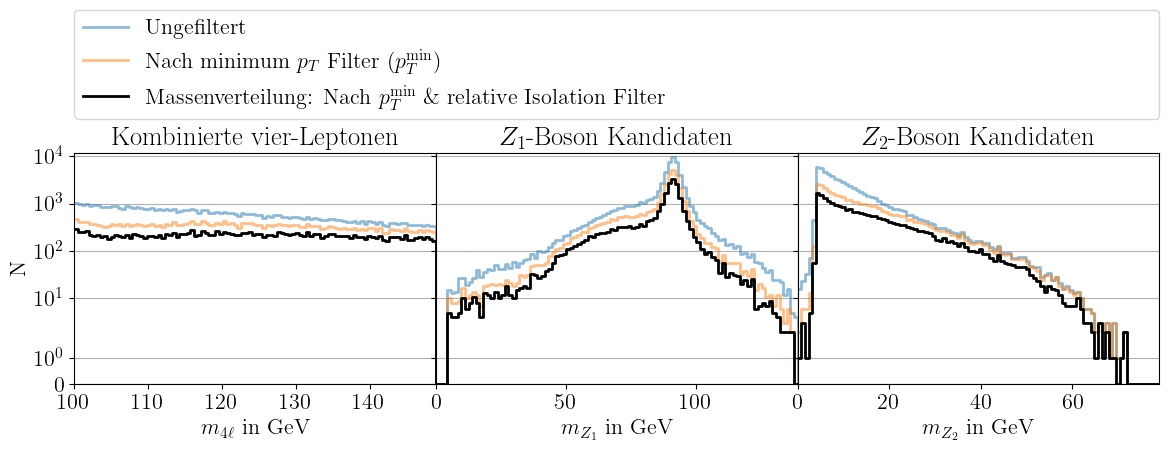

Filer: relative_isolation_of_lepton; Number of events: 39935 -> 25380; Relative change: -36.45%
Filer: min_pt_of_lepton; Number of events: 25380 -> 23516; Relative change: -7.34%


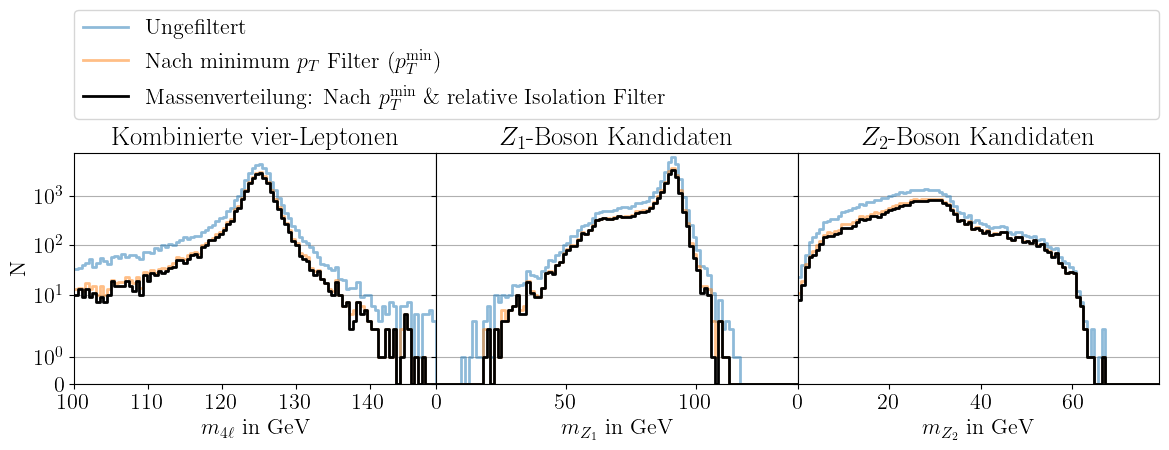

In [13]:
filter_arguments["relative_isolation_value"] = 0.4

pprint(filter_arguments)

_ = (
    dfb
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name="Ungefiltert", show_plot=False)
        # ---
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach minimum $p_T$ Filter ($p_T^{\mathrm{min}}$)", show_plot=False)
        # ---
        .pipe(Filter.relative_isolation_of_lepton, relative_isolation_value=filter_arguments["relative_isolation_value"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="relative_isolation_of_lepton")
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relative Isolation Filter")
)

_ = (
    dfs
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name="Ungefiltert", show_plot=False)
        # ---
        .pipe(Filter.relative_isolation_of_lepton, relative_isolation_value=filter_arguments["relative_isolation_value"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="relative_isolation_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach minimum $p_T$ Filter ($p_T^{\mathrm{min}}$)", show_plot=False)
        # ---
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relative Isolation Filter")
)

---

Zum Abschluss kann ein Filter auf die beiden Z-Bosonen Massen angewendet werden. Dieser Filter nutzt aus, dass das Z-Boson eine Resonanz bei einer Masse von $91\, \mathrm{GeV}/c^2$ hat. Die Anwendung des ersten Filters auf die Masse des $Z_1$-Boson Kandidaten geht davon aus, dass das gefundene Z-Boson in der Nähe dieser Resonanz liegt. Wenn das Higgs-Boson in zwei Z-Bosonen zerfällt, wird erwartet, dass das zweite Z-Boson eine geringere invariante Masse als $91, \mathrm{GeV}/c^2$ hat, um additiv im Bereich der Higgs-Boson-Masse von $125\,\mathrm{GeV}/c^2$ zu sein. Der Filter auf die Masse des $Z_2$-Bosons kann entsprechend so eingestellt werden, dass diese kleiner und damit virtuell ist. Dadurch werden insbesondere Ereignisse unterdrückt, bei denen zwei reelle Z-Bosonen entstehen, sowie Ereignisse mit zwei virtuellen Z-Bosonen. Dies führt zu einer stärkeren Reduzierung des Untergrunds im Vergleich zum Signal.

<div class="alert alert-info">
    Wähle passende Werte für die minimalen und maximalen $Z_1$ und $Z_2$ Massen aus. Das Fenster der $Z_1$-Bosonen Masse kann hierbei etwa $60\,\mathrm{GeV}/c^2$ um die nominale Z-Boson Masse annehmen.
    Wende diesen Filter auf Signal und Untergrundsimulation einzeln und in Kombination mit den vorherigen Filtern an (Da diese Filter nicht einzelne Leptonen, rausfiltert, ist ein anschließendes Anwenden von dem `min_lepton_number` und `neutral_charge` Filter nicht notwendig).
    Entfernt dieser Filter tatsächlich die Untergrundereignisse als Signalereignisse?
</div>

{'min_pt_electron': 7,
 'min_pt_muon': 5,
 'relative_isolation_value': 0.4,
 'z1_mass_max': 120,
 'z1_mass_min': 40,
 'z2_mass_max': 60,
 'z2_mass_min': 12}
Filer: min_pt_of_lepton; Number of events: 66192 -> 37085; Relative change: -43.97%
Filer: relative_isolation_of_lepton; Number of events: 37085 -> 23500; Relative change: -36.63%
Filer: z_masses; Number of events: 23500 -> 12194; Relative change: -48.11%


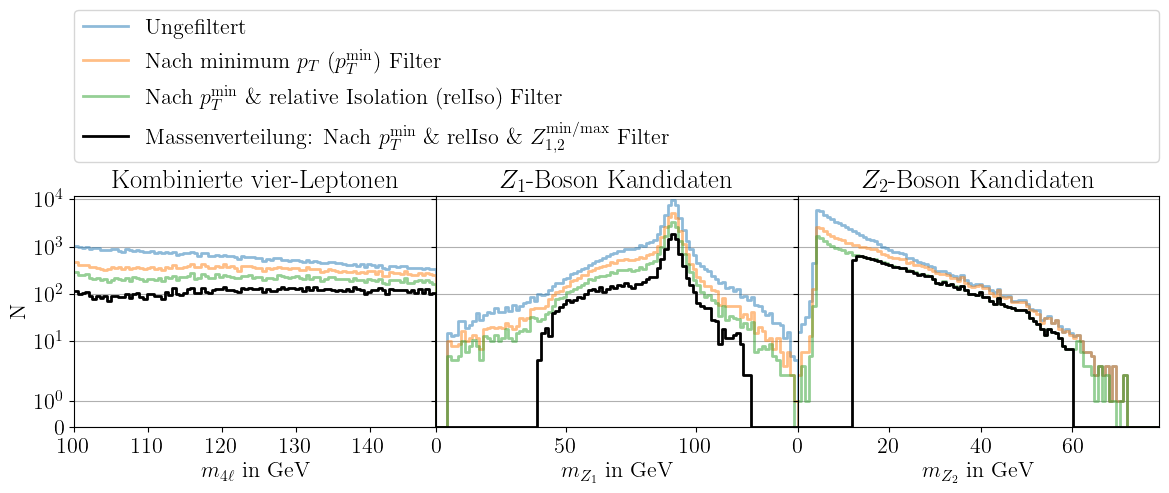

Filer: min_pt_of_lepton; Number of events: 39935 -> 34387; Relative change: -13.89%
Filer: relative_isolation_of_lepton; Number of events: 34387 -> 23516; Relative change: -31.61%
Filer: z_masses; Number of events: 23516 -> 21480; Relative change: -8.66%


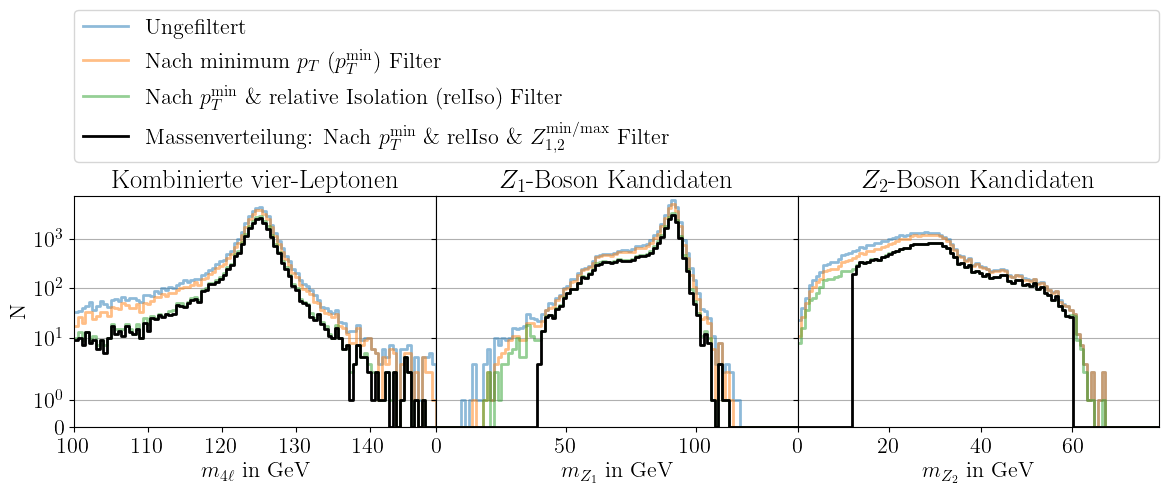

In [14]:
filter_arguments["z1_mass_min"] = 40 
filter_arguments["z1_mass_max"] = 120
filter_arguments["z2_mass_min"] = 12
filter_arguments["z2_mass_max"] = 60

pprint(filter_arguments)

_ = (
    dfb
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name="Ungefiltert", show_plot=False)
        # ---
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach minimum $p_T$ ($p_T^{\mathrm{min}}$) Filter", show_plot=False)
        # ---
        .pipe(Filter.relative_isolation_of_lepton, relative_isolation_value=filter_arguments["relative_isolation_value"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="relative_isolation_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relative Isolation (relIso) Filter", show_plot=False)
        # ---
        .pipe(
            Filter.z_masses, 
            z1_mass_min=filter_arguments["z1_mass_min"], 
            z1_mass_max=filter_arguments["z1_mass_max"], 
            z2_mass_min=filter_arguments["z2_mass_min"], 
            z2_mass_max=filter_arguments["z2_mass_max"],
        )
        # ---
        .pipe(print_n_events_change, filter_name="z_masses")
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relIso \& $Z_{1,2}^{\mathrm{min/max}}$ Filter")
)

_ = (
    dfs
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name="Ungefiltert", show_plot=False)
        # ---
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach minimum $p_T$ ($p_T^{\mathrm{min}}$) Filter", show_plot=False)
        # ---
        .pipe(Filter.relative_isolation_of_lepton, relative_isolation_value=filter_arguments["relative_isolation_value"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="relative_isolation_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relative Isolation (relIso) Filter", show_plot=False)
        # ---
        .pipe(
            Filter.z_masses, 
            z1_mass_min=filter_arguments["z1_mass_min"], 
            z1_mass_max=filter_arguments["z1_mass_max"], 
            z2_mass_min=filter_arguments["z2_mass_min"], 
            z2_mass_max=filter_arguments["z2_mass_max"],
        )
        # ---
        .pipe(print_n_events_change, filter_name="z_masses")
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relIso \& $Z_{1,2}^{\mathrm{min/max}}$ Filter")
)

Nach der Wahl der Filtergrenzen sollten diese endgültig auf die Datensätze, inklusive der tatsächlichen Messung, angewendet werden, ohne sie noch einmal zu ändern. Es empfiehlt sich, eine Kopie dieses Datensatzes zu erstellen, um den ursprünglichen Datensatz zu erhalten. Wenn die Datensätze groß sind, kann dies RAM belegen, der nicht zur Verfügung steht. Da die hier verwendeten Datensätze eine überschaubare Größe haben können wir es aber problemlos machen.

Die Anwendung der implementierten Filter auf die simulierten Datensätze erfolgt wie bereits oben skizziert und durchgeführt. Es sollten alle implementierten Filter auf den Signal- und Untergrunddatensatz sowie auf die durchgeführte Messung (übernächste Code Zelle) angewendet werden. Falls einige Filter ausgelassen oder zusätzliche Filter im Verlauf erstellt wurden, können diese wie oben beschrieben für die drei Datensätze hinzugefügt werden.

In [15]:
print("Background simulation")
dfb_processed = (
    dfb
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # ---
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(Filter.relative_isolation_of_lepton, relative_isolation_value=filter_arguments["relative_isolation_value"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="relative_isolation_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(
            Filter.z_masses, 
            z1_mass_min=filter_arguments["z1_mass_min"], 
            z1_mass_max=filter_arguments["z1_mass_max"], 
            z2_mass_min=filter_arguments["z2_mass_min"], 
            z2_mass_max=filter_arguments["z2_mass_max"],
        )
        # ---
        .pipe(print_n_events_change, filter_name="z_masses")
        # ---
)

print("Signal simulation")
dfs_processed = (
    dfs
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # ---
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(Filter.relative_isolation_of_lepton, relative_isolation_value=filter_arguments["relative_isolation_value"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="relative_isolation_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(
            Filter.z_masses, 
            z1_mass_min=filter_arguments["z1_mass_min"], 
            z1_mass_max=filter_arguments["z1_mass_max"], 
            z2_mass_min=filter_arguments["z2_mass_min"], 
            z2_mass_max=filter_arguments["z2_mass_max"],
        )
        # ---
        .pipe(print_n_events_change, filter_name="z_masses")
        # ---
)

Background simulation
Filer: min_pt_of_lepton; Number of events: 66192 -> 37085; Relative change: -43.97%
Filer: relative_isolation_of_lepton; Number of events: 37085 -> 23500; Relative change: -36.63%
Filer: z_masses; Number of events: 23500 -> 12194; Relative change: -48.11%
Signal simulation
Filer: min_pt_of_lepton; Number of events: 39935 -> 34387; Relative change: -13.89%
Filer: relative_isolation_of_lepton; Number of events: 34387 -> 23516; Relative change: -31.61%
Filer: z_masses; Number of events: 23516 -> 21480; Relative change: -8.66%


Nachdem alle Filter auf den simulierten Datensatz angewendet wurden, ist es Zeit nun die Filter auf die tatsächliche Messunganzuwenden. Bei den Effekten der einzelnen Filterschritte wird eine kleine Änderung in der Darstellung vorgenommen: eine Aufteilung der y-Achsen Skala in zwei Teile. Der untere Teil hat eine lineare Skala von 0 bis zu einem bestimmten Wert, den wir als `yedge` bezeichnen. Der obere Teil der y-Achse hat eine logarithmische Skala, die von `yedge` bis unendlich geht. Wir wählen diese Darstellung, weil die Filter auf den Messdaten einen viel stärkeren Effekt haben und schnell viele Größenordnungen an Messdaten herausfiltern. Die logarithmische Skala eignet sich hierfür gut, wie oben bereits verwendet und gezeigt wurde. Wenn jedoch nur wenige Ereignisse vorliegen, kann zur einer besseren Darstellung eine lineare Skala verwendet werden. Wenn dies nicht gewünscht ist, kann in `plotting_dict` der Eintrag `"yedge": None` gesetzt werden.

{'min_pt_electron': 7,
 'min_pt_muon': 5,
 'relative_isolation_value': 0.4,
 'z1_mass_max': 120,
 'z1_mass_min': 40,
 'z2_mass_max': 60,
 'z2_mass_min': 12}
Filer: min_pt_of_lepton; Number of events: 5337 -> 1354; Relative change: -74.63%
Filer: relative_isolation_of_lepton; Number of events: 1354 -> 58; Relative change: -95.72%
Filer: z_masses; Number of events: 58 -> 24; Relative change: -58.62%


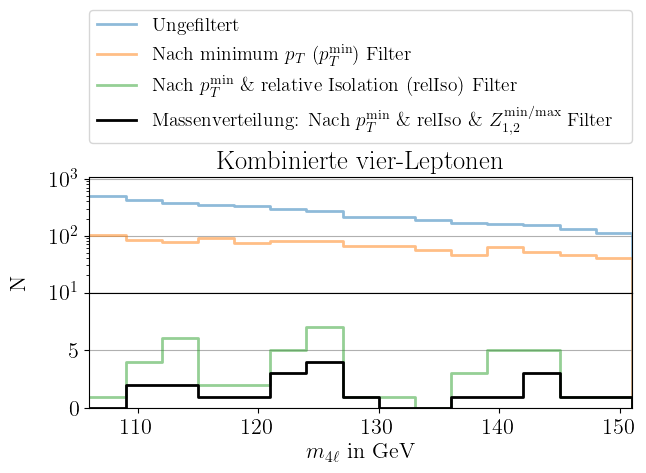

In [16]:
plotting_dict = {"four_lep_bins": 15, "four_lep_range": (106, 151), "show_z1_and_z2_mass": False, "xdim": 7, "yedge": 9.9} 

pprint(filter_arguments)

dfm_processed = (
    dfm
        .pipe(clear_hist_plots)
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name="Ungefiltert", show_plot=False, **plotting_dict)
        # ---
        .pipe(Filter.min_pt_of_lepton, min_pt_electron=filter_arguments["min_pt_electron"], min_pt_muon=filter_arguments["min_pt_muon"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="min_pt_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach minimum $p_T$ ($p_T^{\mathrm{min}}$) Filter", show_plot=False, **plotting_dict)
        # ---
        .pipe(Filter.relative_isolation_of_lepton, relative_isolation_value=filter_arguments["relative_isolation_value"])
        .pipe(Filter.min_lepton_number)
        .pipe(Filter.neutral_charge)
        # ---
        .pipe(print_n_events_change, filter_name="relative_isolation_of_lepton")
        .pipe(set_n_events)
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relative Isolation (relIso) Filter", show_plot=False, **plotting_dict)
        # ---
        .pipe(
            Filter.z_masses, 
            z1_mass_min=filter_arguments["z1_mass_min"], 
            z1_mass_max=filter_arguments["z1_mass_max"], 
            z2_mass_min=filter_arguments["z2_mass_min"], 
            z2_mass_max=filter_arguments["z2_mass_max"],
        )
        # ---
        .pipe(print_n_events_change, filter_name="z_masses")
        # ---
        .pipe(plot_masses, filter_name=r"Nach $p_T^{\mathrm{min}}$ \& relIso \& $Z_{1,2}^{\mathrm{min/max}}$ Filter", **plotting_dict)
)


Kommen wir nun zum Vergleich zwischen den simulierten - erwarteten Datensätzen - und der durchgeführten Messung. Die Idee hierzu ist, dass die simulierten Datensätze an die Luminosität (dem Datenumfang der Messung) und dem jeweiligen Zerfallskanal (vier Myonen, vier Elektronen oder zwei Elektronen und zwei Myonen) skaliert werden, da diese in der Regel viel mehr Ereignisse enthalten, um eine bessere Beschreibung der Erwartung zu erhalten. Diese Skalierung ist nicht schwer, jedoch kann diese übersprungen werden, da nichts Spannendes dort passiert. Aus diesem Grund habe ich dir das abgenommen. Die Hilfsfunktion `plot_mc_data_comparison` ist ebenfalls in der Datei mit den Hilfsfunktionen enthalten.


Kommen wir jetzt zum Vergleich zwischen den simulierten - erwarteten Datensätzen - und der durchgeführten Messung. Es ist wichtig, einen Vergleich zwischen Simulation und Messung durchzuführen, da wir durch die Simulation eine erwartete Verteilung der Ereignisse haben. Der Vergleich hilft uns zu verstehen, ob unsere Simulation den tatsächlichen Messdaten entspricht oder ob wir Änderungen an unserer Simulation vornehmen müssen. Da die Simulationen anhand der uns bekannten physikalischen Prozessen durchgeführt wird, hilft dieser Vergleich die uns bekannte Theorie über die fundamentalen Teilchen und deren Wechselwirkungen zu verbessern.

Eine Skalierung der simulierten Datensätze an die Luminosität und den Zerfallskanal ist wichtig, um eine genauere Beschreibung der erwarteten Verteilung zu erhalten. Eine explizite Durchführung der Skalierung ist jedoch nicht notwendig. Die grundlegende Idee hierzu ist, dass die simulierten Datensätze an die Luminosität (dem Datenumfang der Messung) und dem jeweiligen Zerfallskanal (vier Myonen, vier Elektronen oder zwei Elektronen und zwei Myonen) einzeln skaliert werden, in diesem Fall, nachdem die Histogramme der einzelnen Zerfallskanäle gebildet wurden. Dies ist jedoch keine wirklich spannende Aufgabe und wird deshalb in der Hilfsfunktion automatisch ausgeführt. 

Die Darstellung erfolgt über die Hilfsfunktion `plot_mc_data_comparison` welche in der Datei mit den Hilfsfunktionen enthalten ist und gibt neben der Darstellung auch die Einträge der Histogramme von dem erwarteten Untergrund aus der Simulation und der tatsächlichen Messung. Die Einträge des Histogramms von dem erwarteten Signal werden nicht zurückgegeben, da es als nächste Aufgabe zu bestimmen ist, ob das beobachtete Signal überhaupt signifikant ist. Aus diesem Grund wird für die Bestimmung der Anzahl der beobachteten Signalereignisse die Differenz zwischen er durchgeführten Messung und dem erwarteten Untergrund bestimmt. Die Verwendung der Untergrunderwartung ist an dieser Stelle im Gegensatz zu der Signalerwartung möglich, da der Untergrund bereits aus anderen Experimenten bestätigt wurde.
<div class="alert alert-info">
    An welcher Stelle gibt es Überschüsse von dem erwarteten Untergrund?
    Sind alle Überschüsse im Rahmen ihrer Unsicherheit noch kompatibel mit dem erwarteten Untergrund?
</div>

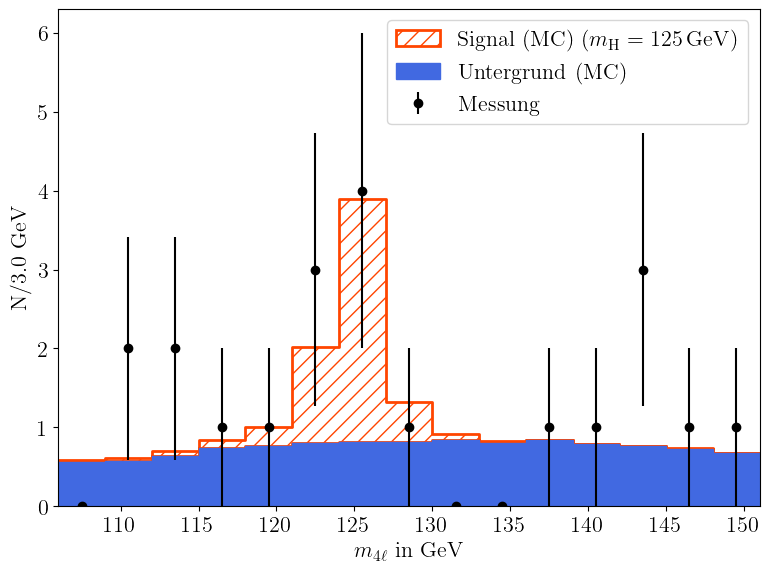

In [17]:
from utils import plot_mc_data_comparison
bkg_sim_bins, data_bins = plot_mc_data_comparison(dfm_processed, dfs_processed, dfb_processed)

Die Beurteilung, ob die beobachtete Überhöhung, welche durch die Signalerwartung erklärt werden kann, überhaupt signifikant ist und ob sie tatsächlich auf ein Higgs-artiges Boson mit einer Masse von 125 GeV zurückzuführen ist, ist der letzte Teil des Notebooks. Die Frage nach der Signifikanz ist der Teilchenphysik zentral und gilt zu beantworten, wenn beispielsweise neue Teilchen oder Prozesse beobachtet werden und ob diese nicht auch durch die Fluktuation des Untergrundes erklärt werden können. Eine Abschätzung der Signifikanz kann als die Abweichung der beobachteten Messung von dem erwarteten Untergrund in Einheiten der Standardabweichung angegeben. Der Grundgedanke ist, dass eine große Abweichung der Messung vom erwarteten Untergrund signifikanter ist als eine kleine Abweichung.

Ein grober Schätzwert für die Signifikanz kann durch die Formel $Z = \frac{s}{\sqrt{b}}$ berechnet werden. Hierbei steht $s$ für die Anzahl der beobachteten Signalereignisse und $b$ für die Anzahl der erwarteten Untergrundereignisse verwendet. Entsprechend ist $\sqrt{b}$ die Unsicherheit auf den Untergrund, da es sich um ein Poisson Prozess handelt. Wie oben beschrieben, wird die Anzahl der Signalereignisse über die Differenz zwischen der Anzahl an beobachteten Ereignissen und dem erwarteten Untergrund bestimmt. Wenn der erwartete Untergrund sehr hoch ist, wird die Beobachtung einer signifikanten Abweichung schwieriger sein als bei einem geringeren Untergrund, da die Unsicherheit auf den Untergrund dominieren wird, wodurch das Verhältnis klein wird. Wie oben bei der Darstellung zu sehen ist, kann der Signalprozess aber deutlich von dem Untergrund unterschieden werden, was der Vorteil von dem $\mathrm{H}\rightarrow ZZ\rightarrow 4\ell$ Zerfallskanal ist. Dies ist auch der Grund, warum dieser Zerfallskanal, trotz seiner geringen Wahrscheinlichkeit im Vergleich zu anderen Zerfallskanälen eine wichtige Rolle bei der Entdeckung des Higgs Bosons gespielt hat.

Eine Signifikanz von $3\sigma$ gilt in der Teilchenphysik als ein Hinweis auf einen möglichen neuen Prozess oder Teilchen, während ab $5\sigma$ von einer Entdeckung gesprochen wird. Bei der Entdeckung des Higgs Bosons wurden für das Erreichen der $5\sigma$ Grenze hierbei mehrere Zerfallskanäle kombiniert.

<div class="alert alert-info">
    Ist der beobachtete Überschuss in der Messung, der durch ein Higgs Boson von Masse $125\,\mathrm{GeV}/c^2$ erkärt werden kann, signifikant?
    Wie groß ist diese Signifikanz? Kann hier schon von einer Entdeckung gesprochen werden?
    Wie kann die Signifikanz verbessert werden?
    Spielt die Wahl der Grenzen des Histogramms und der Anzahl der Bins eine Rolle bei der Bestimmung der Signifikanz, wie sie oben definiert ist?
</div>

Die Fragen können ebenfalls in eine Weiterführende Diskussion übergeführt werden.

In [18]:
print("Binned measurement:")
pprint(data_bins)
print("Binned background simulation:") 
pprint(bkg_sim_bins)

Binned measurement:
array([0, 2, 2, 1, 1, 3, 4, 1, 0, 0, 1, 1, 3, 1, 1])
Binned background simulation:
array([0.56786525, 0.5738775 , 0.64363552, 0.74337222, 0.76651536,
       0.80077621, 0.81329442, 0.812883  , 0.84384962, 0.80242308,
       0.83693113, 0.79204557, 0.76865599, 0.73217109, 0.68127328])


In [19]:
selected_bins = [4, 5, 6, 7]
summed_data = data_bins[selected_bins].sum()
summed_bkg_sim = bkg_sim_bins[selected_bins].sum()
estimated_significance = (summed_data - summed_bkg_sim) / np.sqrt(summed_bkg_sim)
print(f"Estimated significance: {round(estimated_significance, 2)}σ")

Estimated significance: 3.25σ
